In [ ]:
#pip install xgboost

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date 



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-card-fraud-data/fraud_data.csv


In [2]:
credit_file_path = "/kaggle/input/credit-card-fraud-data/fraud_data.csv"
credit_data = pd.read_csv(credit_file_path) 

credit_data

,trans_date_trans_time,merchant,category,amt,city,state,lat,long,city_pop,job,dob,trans_num,merch_lat,merch_long,is_fraud
0,04-01-2019 00:58,"""Stokes, Christiansen and Sipes""",grocery_net,14.37,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a3806e984cec6ac0096d8184c64ad3a1,65.654142,-164.722603,1
1,04-01-2019 15:06,Predovic Inc,shopping_net,966.11,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,a59185fe1b9ccf21323f581d7477573f,65.468863,-165.473127,1
2,04-01-2019 22:37,Wisozk and Sons,misc_pos,49.61,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,86ba3a888b42cd3925881fa34177b4e0,65.347667,-165.914542,1
3,04-01-2019 23:06,Murray-Smitham,grocery_pos,295.26,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,3a068fe1d856f0ecedbed33e4b5f4496,64.445035,-166.080207,1
4,04-01-2019 23:59,Friesen Lt,health_fitness,18.17,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,891cdd1191028759dc20dc224347a0ff,65.447094,-165.446843,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14441,22-01-2019 00:37,Hudson-Grady,shopping_pos,122.00,Athena,OR,45.8289,-118.4971,1302,Dealer,18-10-1976,699a4c06b22711bf3e0d8ef91232d356,46.442439,-118.524214,0
14442,22-01-2019 00:41,"""Nienow, Ankunding and Collie""",misc_pos,9.07,Gardiner,OR,43.7857,-124.1437,260,"""Engineer, maintenance""",01-09-1956,080d620d24815c7d6c637cf0b71dde8e,42.901265,-124.995317,0
14443,22-01-2019 00:42,Pacocha-O'Reilly,grocery_pos,104.84,Alva,WY,44.6873,-104.4414,110,"""Administrator, local government""",16-05-1973,3c346c8cd627c5fe3ed57430db2e9ae7,45.538062,-104.542117,0
14444,22-01-2019 00:48,"""Bins, Balistreri and Beatty""",shopping_pos,268.16,Wales,AK,64.7556,-165.6723,145,"""Administrator, education""",09-11-1939,e66ffcc95ba7fc490486242af1205d04,64.081462,-165.898698,0


# Data Visualization

In [4]:
for i, born in enumerate(credit_data["dob"]):
    born = datetime.strptime(born, "%d-%m-%Y").date()
    
    today = date.today() 
    
    cal_age = today.year - born.year - ((today.month, today.day) < (born.month, born.day))
    
    credit_data.at[i, 'dob'] = cal_age
    
#print(credit_data["dob"].head())

TypeError: strptime() argument 1 must be str, not int

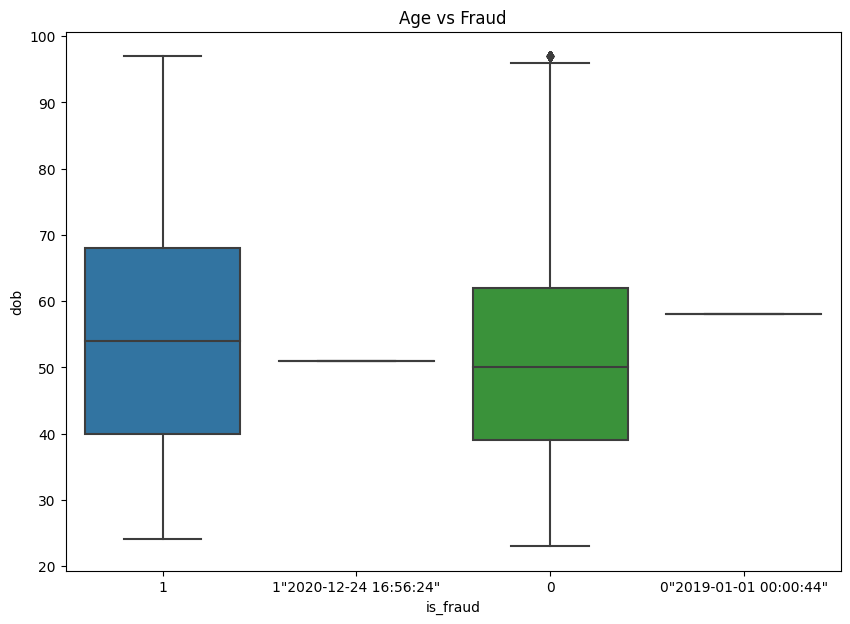

In [5]:
plt.figure(figsize=(10,7))

plt.subplot(1,1,1)
plt.title("Age vs Fraud")
sns.boxplot(x = "is_fraud", y = "dob", data = credit_data)

plt.show()

In [6]:
credit_data['trans_date_trans_time'] = pd.to_datetime(credit_data['trans_date_trans_time'], format='%d-%m-%Y %H:%M')
print(credit_data)
credit_data['timestamp'] = credit_data['trans_date_trans_time'].apply(lambda x: x.timestamp())
credit_data['timestamp'] = (credit_data['trans_date_trans_time'].view('int64') / 10**9)
credit_data = credit_data.drop(columns=["trans_date_trans_time"])
print(credit_data)

      trans_date_trans_time                          merchant        category  \
0       2019-01-04 00:58:00  "Stokes, Christiansen and Sipes"     grocery_net   
1       2019-01-04 15:06:00                      Predovic Inc    shopping_net   
2       2019-01-04 22:37:00                   Wisozk and Sons        misc_pos   
3       2019-01-04 23:06:00                    Murray-Smitham     grocery_pos   
4       2019-01-04 23:59:00                        Friesen Lt  health_fitness   
...                     ...                               ...             ...   
14441   2019-01-22 00:37:00                      Hudson-Grady    shopping_pos   
14442   2019-01-22 00:41:00    "Nienow, Ankunding and Collie"        misc_pos   
14443   2019-01-22 00:42:00                  Pacocha-O'Reilly     grocery_pos   
14444   2019-01-22 00:48:00     "Bins, Balistreri and Beatty"    shopping_pos   
14445   2019-01-22 00:55:00                Daugherty-Thompson     food_dining   

          amt        city s

/tmp/ipykernel_35/3653700565.py:4: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  credit_data['timestamp'] = (credit_data['trans_date_trans_time'].view('int64') / 10**9)


In [8]:
"""
#df['Species'] = df['Species'].apply(lambda x: 0 if x=='Iris-setosa' else x)
fig = plt.figure(figsize =(10, 7))

# Creating plot
plt.boxplot(credit_data)

# show plot
plt.show()
"""
#preprocess



le = LabelEncoder()
for column in credit_data.select_dtypes(include='object').columns:
    credit_data[column] = le.fit_transform(credit_data[column])
    
print(credit_data)

X = credit_data.drop(columns=["is_fraud"]).values
y = credit_data["is_fraud"].values#target to predict


X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)
#print(X_test.shape)
#print(X_train.shape)
#print(y_test.shape)
#print(X_train.shape)

# scale the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#xgb_train
xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)



       merchant  category     amt  city  state      lat      long  city_pop  \
0           179         3   14.37   166      0  64.7556 -165.6723       145   
1           564        11  966.11   166      0  64.7556 -165.6723       145   
2           682         9   49.61   166      0  64.7556 -165.6723       145   
3           537         4  295.26   166      0  64.7556 -165.6723       145   
4           352         5   18.17   166      0  64.7556 -165.6723       145   
...         ...       ...     ...   ...    ...      ...       ...       ...   
14441       411        12  122.00     8      9  45.8289 -118.4971      1302   
14442       126         9    9.07    48      9  43.7857 -124.1437       260   
14443       549         4  104.84     2     12  44.6873 -104.4414       110   
14444        14        12  268.16   166      0  64.7556 -165.6723       145   
14445       311         1   50.09   160      6  40.4815  -92.9951      3805   

       job  dob  trans_num  merch_lat  merch_long  

In [ ]:
#these parameters need to be edited to find the optimal settings for our data
#also the settings that the user will edit in the app
n=50
params={
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}


# model training

model =xgb.train(params=params,dtrain=xgb_train,num_boost_round=n)


# predict frauda
preds = model.predict(xgb_test)
preds = preds.astype(int)

#accuracy
accuracy= accuracy_score(y_test,preds)
print("accuracy=", accuracy)
# evaluate model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")